In [1]:
# forecast monthly births with xgboost
import pandas as pd
from numpy import asarray
from pandas import read_excel
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from xgboost import plot_importance, plot_tree, to_graphviz
from xgboost import XGBRegressor
from matplotlib import pyplot
import holidays
import datetime
from datetime import date
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
pyplot.style.use('fivethirtyeight')

Mais qu’est-ce que le Boosting de Gradient ?
Le Boosting de Gradient est un algorithme d’apprentissage supervisé dont le principe et de combiner les résultats d’un ensemble de modèles plus simple et plus faibles afin de fournir une meilleur prédiction.
On parle d’ailleurs de méthode d’agrégation de modèles. L’idée est donc simple : au lieu d’utiliser un seul modèle, l’algorithme va en utiliser plusieurs qui serons ensuite combinés pour obtenir un seul résultat.

In [2]:
# xgboost
import xgboost
print("xgboost", xgboost.__version__)

xgboost 1.3.3


In [3]:
df = pd.read_parquet('dataset\\est_hourly.parquet')
df = df.fillna(0)
# 4 doublons seulement => suppression du premier enregistrement
data_clean = df[~df.index.duplicated(keep='first')].copy()
##### Contrôles des dates manquantes
#Ajout de colonnes pour décomposer l'index Datetime en colonnes 'Année','Mois','Jour','Heure'
data_clean['date'] = data_clean.index.date
data_clean['annee'] = data_clean.index.year
data_clean['mois'] = data_clean.index.month
data_clean['semaine'] = data_clean.index.week
data_clean['heure'] = data_clean.index.hour
data_clean['jour_annee'] = data_clean.index.dayofyear
data_clean['trimestre'] = data_clean.index.quarter
data_clean['jour_semaine'] = data_clean.index.dayofweek
data_clean['jour_mois'] = data_clean.index.day
#### Pour éviter de biaiser nos résultats on supprime les données entre 1998 à 2004
#### Suppression des données avant 2005 
data_clean = data_clean[data_clean['annee'] > 2004]
#Liste des jours pour lesquels il manque au moins une observation
checkmonth=pd.DataFrame(data_clean.groupby(['jour_annee','annee'])['annee'].count())
checkmonth.rename(columns={'annee':'nb'}, inplace=True)
checkmonth
df_missing=checkmonth[checkmonth.nb!=24]
df_missing=df_missing.reset_index()
df_missing.head(50)
df_missing
Hour0_24=pd.DataFrame(np.arange(24))
df_to_append=pd.DataFrame()
for x,y in zip(df_missing['jour_annee'],df_missing['annee']):
    df_encours=data_clean[(data_clean.jour_annee==x)&(data_clean.annee==y)]
    h_missing=Hour0_24[~Hour0_24[0].isin(df_encours.heure)]
    #print(h_missing.iloc[0].name+1)
    h=h_missing.iloc[0].name
    df_to_append=df_to_append.append(data_clean[(data_clean.jour_annee==x)&(data_clean.annee==y)&(data_clean.heure==(h+1))])

df_to_append.heure=df_to_append.heure-1
data_clean=data_clean.append(df_to_append)
data_clean.sort_index(inplace=True)
data_clean['Total'] = data_clean.apply(lambda x : x.loc['AEP':'PJM_Load'].sum(), axis=1)
data_clean.shape

(119089, 22)

In [4]:
df_feature_total=data_clean[['Total']]
df_feature_total=df_feature_total.reset_index()
df_feature_total=df_feature_total.rename(columns={'Datetime': 'date'})
df_feature_total=df_feature_total.set_index('date')
df_feature_total

,Total
date,
2005-01-01 00:00:00,56671.0
2005-01-01 01:00:00,55633.0
2005-01-01 02:00:00,53143.0
2005-01-01 03:00:00,51172.0
2005-01-01 04:00:00,49990.0
...,...
2018-08-02 20:00:00,119003.0
2018-08-02 21:00:00,116219.0
2018-08-02 22:00:00,112721.0


# Train/Test split

Cut off the data after 2015 to use as our validation set.

In [5]:
split_date = '2015-01-01'
df_features_train = df_feature_total.loc[df_feature_total.index <= split_date].copy()
df_features_test = df_feature_total.loc[df_feature_total.index > split_date].copy()
df_features_test

,Total
date,
2015-01-01 01:00:00,93984.0
2015-01-01 02:00:00,91916.0
2015-01-01 03:00:00,90362.0
2015-01-01 04:00:00,89622.0
2015-01-01 05:00:00,89856.0
...,...
2018-08-02 20:00:00,119003.0
2018-08-02 21:00:00,116219.0
2018-08-02 22:00:00,112721.0


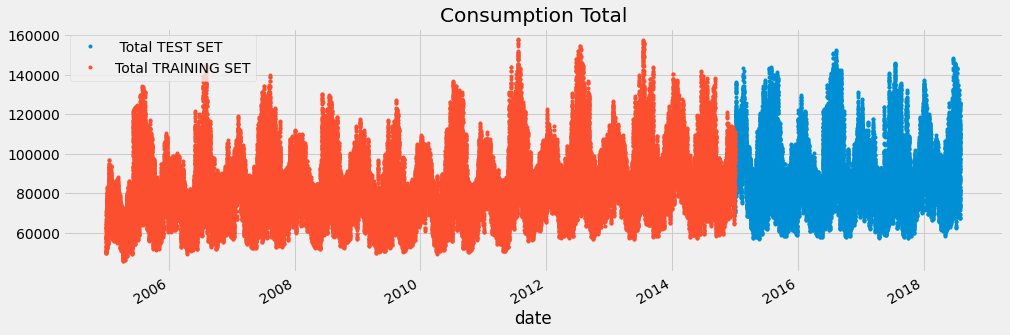

In [6]:
_ = df_features_test \
    .rename(columns={'Total': ' Total TEST SET'}) \
    .join(df_features_train.rename(columns={'Total': 'Total TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Consumption Total', style='.')

In [7]:
df_features_train

,Total
date,
2005-01-01 00:00:00,56671.0
2005-01-01 01:00:00,55633.0
2005-01-01 02:00:00,53143.0
2005-01-01 03:00:00,51172.0
2005-01-01 04:00:00,49990.0
...,...
2014-12-31 20:00:00,108726.0
2014-12-31 21:00:00,106046.0
2014-12-31 22:00:00,103217.0


# Create Time Series Features

In [8]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['season'] = df['date'].apply( lambda x: 1 if x.month == 12 or x.month == 1 or x.month == 2 else 2 if  x.month == 3 or x.month == 4 or x.month == 5 else 3 if  x.month == 6 or x.month == 7 or x.month == 8 else 4 if  x.month == 9 or x.month == 10 or x.month == 11 else '')
    df['holidays'] = df['date'].apply( lambda x: 'Holiday' if x in holidays.US(state=['OH','VI','IL','VA','WV','KY','PA']) else 'Holiday' if x + datetime.timedelta(days=1) in holidays.US(state=['OH','VI','IL','VA','WV','KY','PA']) else 'Normal day' )
    df['day_off']=np.where((df['dayofweek']>4),0,1)
    df['day_off']=np.where((df['holidays']=='Holiday'),df['day_off'],0)
    #drop week_ebd column
    df.drop(columns=['holidays'],axis=1,inplace=True)
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','season','day_off']]
    if label:
        y = df[label]
        return X, y
    return X

In [9]:
X_train, y_train = create_features(df_features_train, label='Total')
X_test, y_test = create_features(df_features_test, label='Total')
X_test

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,day_off
date,,,,,,,,,,
2015-01-01 01:00:00,1,3,1,1,2015,1,1,1,1,1
2015-01-01 02:00:00,2,3,1,1,2015,1,1,1,1,1
2015-01-01 03:00:00,3,3,1,1,2015,1,1,1,1,1
2015-01-01 04:00:00,4,3,1,1,2015,1,1,1,1,1
2015-01-01 05:00:00,5,3,1,1,2015,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,20,3,3,8,2018,214,2,31,3,0
2018-08-02 21:00:00,21,3,3,8,2018,214,2,31,3,0
2018-08-02 22:00:00,22,3,3,8,2018,214,2,31,3,0


# Create XGBoost Model

In [10]:
reg = XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train
p_boost = reg.predict(X_train)
print ("Score Train -->", round(reg.score(X_train, y_train) *100,2), " %")

Score Train --> 83.18  %


# Feature Importances

Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.
We can see that the day of year was most commonly used to split trees, while hour and year came in next. Quarter has low importance due to the fact that it could be created by different dayofyear splits.

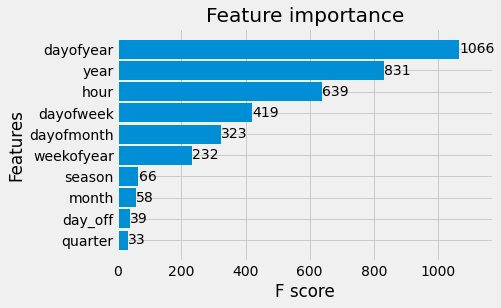

In [11]:
_ = xgboost.plot_importance(reg, height=0.9)

Ealuation:la librairie XGBoost founit quelques métriques intéressantes.
Graphique présentant les champs par degré d’importance : dayofyear,year,hour,dayofweek

# Forecast on Test Set

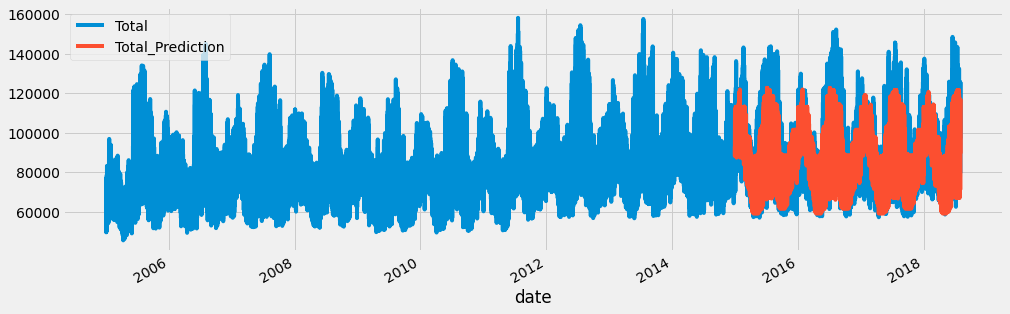

In [12]:
df_features_test['Total_Prediction'] = reg.predict(X_test)
df_features_all = pd.concat([df_features_test, df_features_train], sort=False)
_ = df_features_all[['Total','Total_Prediction']].plot(figsize=(15, 5))

# Look at first month of predictions

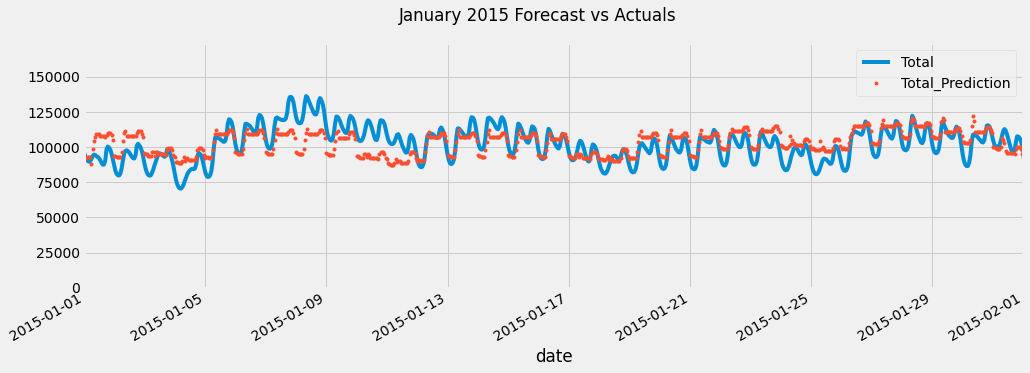

In [13]:
# Plot the forecast with the actuals
f, ax = pyplot.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_features_all[['Total','Total_Prediction']].plot(ax=ax,style=['-','.'])
ax.set_xbound(lower='2015-01-01', upper='2015-02-01')
ax.set_ylim(0, df_features_all[['Total_Prediction','Total']].max().max()+df_features_all[['Total_Prediction','Total']].max().max()*0.1)
plot = pyplot.suptitle('January 2015 Forecast vs Actuals')

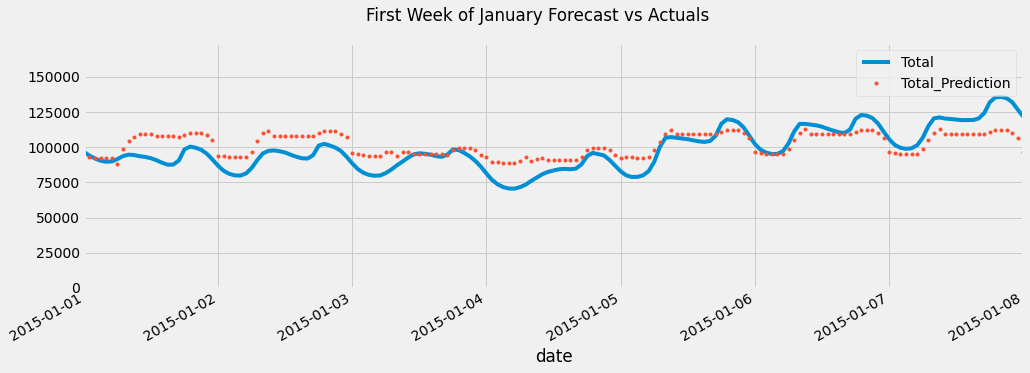

In [14]:
# Plot the forecast with the actuals
f, ax = pyplot.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_features_all[['Total','Total_Prediction']].plot(ax=ax,style=['-','.'])
ax.set_xbound(lower='2015-01-01', upper='2015-01-08')
ax.set_ylim(0, df_features_all[['Total_Prediction','Total']].max().max()+df_features_all[['Total_Prediction','Total']].max().max()*0.1)
plot = pyplot.suptitle('First Week of January Forecast vs Actuals')

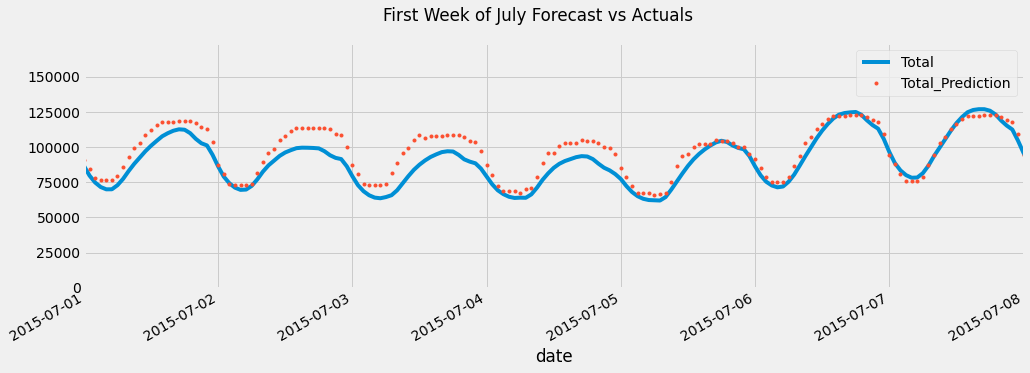

In [15]:
f, ax = pyplot.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_features_all[['Total','Total_Prediction']].plot(ax=ax,style=['-','.'])
ax.set_ylim(0, df_features_all[['Total_Prediction','Total']].max().max()+df_features_all[['Total_Prediction','Total']].max().max()*0.1)
ax.set_xbound(lower='2015-07-01', upper='2015-07-08')
plot = pyplot.suptitle('First Week of July Forecast vs Actuals')

# Error Metrics On Test Set

In [16]:
mean_squared_error(y_true=df_features_test['Total'],
                   y_pred=df_features_test['Total_Prediction'])

98093253.29385865

In [17]:
mean_absolute_error(y_true=df_features_test['Total'],
                   y_pred=df_features_test['Total_Prediction'])

7429.3158368370305

I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are. MAPE isn't included in sklearn so we need to use a custom function.

In [18]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [19]:
MAPE=mean_absolute_percentage_error(y_true=df_features_test['Total'],
                   y_pred=df_features_test['Total_Prediction'])
print ("We got a MAPE of : ", round(MAPE,2), " %")#8.007

We got a MAPE of :  8.01  %


# Look at Worst and Best Predicted Days

In [20]:
df_features_test['error'] = df_features_test['Total'] - df_features_test['Total_Prediction']
df_features_test['abs_error'] = df_features_test['error'].apply(np.abs)
error_by_day = df_features_test.groupby(['year','month','dayofmonth']) \
    .mean()[['Total','Total_Prediction','error','abs_error']]

In [21]:
#df_features_test#holidays.US(state='CA', years=2017).items()

In [22]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

Total  Total_Prediction         error  \
year month dayofmonth                                                 
2016 7     4           77738.666667     100939.390625 -23200.724935   
2017 1     25          89063.041667     111608.062500 -22545.023438   
     2     24          78321.291667     100587.187500 -22265.895508   
2018 1     28          79806.916667     101769.984375 -21963.066406   
2017 1     26          89983.791667     111608.062500 -21624.273438   
     2     8           84773.208333     105891.140625 -21117.935872   
           23          79981.291667     100981.382812 -21000.087565   
2018 1     22          86186.416667     107024.343750 -20837.925456   
2017 1     2           84377.791667     104578.601562 -20200.808919   
2018 1     23          88002.000000     108158.328125 -20156.326823   

                          abs_error  
year month dayofmonth                
2016 7     4           23200.724935  
2017 1     25          22545.023438  
     2     24          22265.895508  
2018 1     28          21963.066406  
2017 1     26          21624.273438  
     2     8           21117.935872  
           23          21000.087565  
2018 1     22          20837.925456  
2017 1     2           20200.808919  
2018 1     23          20156.326823

Notice anything about the over forecasted days?

#1 worst day - July 4th, 2016 - is a holiday.
#3 worst day - December 25, 2015 - Christmas
#5 worst day - July 4th, 2016 - is a holiday.
Looks like our model may benefit from adding a holiday indicator.

In [23]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

,,,Total,Total_Prediction,error,abs_error
year,month,dayofmonth,,,,
2015,2,20,129698.458333,98143.171875,31555.284505,31555.284505
2016,8,13,118206.041667,87496.062500,30709.981120,30709.981120
2018,1,6,125435.291667,95730.414062,29704.880859,29704.880859
2016,8,12,124120.541667,95769.171875,28351.370443,28351.370443
2017,12,31,111350.541667,83441.000000,27909.542643,27909.542643
2018,1,7,120146.583333,92489.351562,27657.231445,27657.231445
2016,8,11,124203.416667,97341.015625,26862.397135,26862.397135
2015,2,19,126590.791667,100114.734375,26476.056315,26476.056315
2016,7,23,115978.375000,89603.335938,26375.038737,26375.038737


The best predicted days seem to be a lot of october (not many holidays and mild weather) Also early may

In [24]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

Total  Total_Prediction        error  \
year month dayofmonth                                                
2016 5     1           70247.333333      69792.609375   454.722819   
2017 10    24          80790.291667      80682.132812   108.155599   
2015 4     20          79013.833333      79821.007812  -807.177734   
     9     26          74017.583333      74749.804688  -732.224772   
2017 4     22          70971.416667      71691.742188  -720.327311   
2016 9     29          80943.000000      80732.312500   210.688151   
2018 4     28          71234.291667      71691.742188  -457.452311   
2015 10    28          81424.833333      80682.132812   742.697266   
2017 5     13          71225.083333      72282.906250 -1057.825358   
           2           80607.166667      81303.726562  -696.558268   

                         abs_error  
year month dayofmonth               
2016 5     1            913.601074  
2017 10    24          1128.666667  
2015 4     20          1151.824219  
     9     26          1169.815267  
2017 4     22          1174.506348  
2016 9     29          1248.494141  
2018 4     28          1278.131999  
2015 10    28          1302.451823  
2017 5     13          1311.180827  
           2           1317.355143

#df_features_test.groupby(['month','day_off']).mean()['Total']

# Plotting some best/worst predicted days

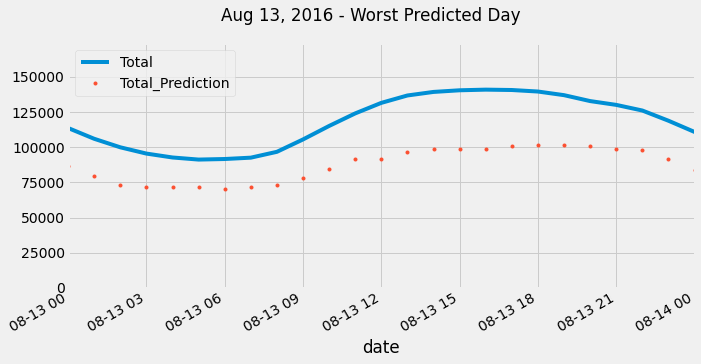

In [25]:
f, ax = pyplot.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = df_features_all[['Total','Total_Prediction']].plot(ax=ax,style=['-','.'])
ax.set_ylim(0, df_features_all[['Total_Prediction','Total']].max().max()+df_features_all[['Total_Prediction','Total']].max().max()*0.1)
ax.set_xbound(lower='2016-08-13', upper='2016-08-14')
plot = pyplot.suptitle('Aug 13, 2016 - Worst Predicted Day')

This one is pretty impressive. SPOT ON!

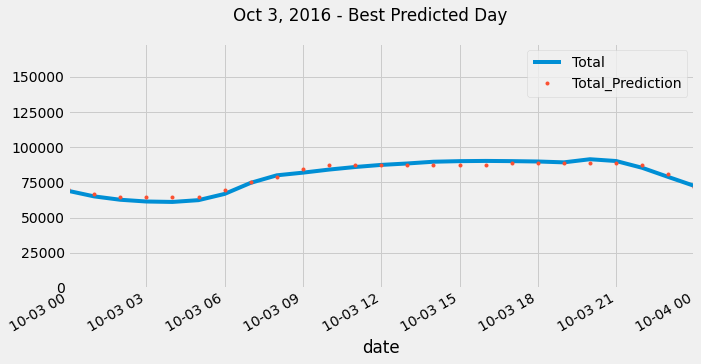

In [26]:
f, ax = pyplot.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = df_features_all[['Total','Total_Prediction']].plot(ax=ax,style=['-','.'])
ax.set_ylim(0, df_features_all[['Total_Prediction','Total']].max().max()+df_features_all[['Total_Prediction','Total']].max().max()*0.1)
ax.set_xbound(lower='2016-10-03', upper='2016-10-04')
plot = pyplot.suptitle('Oct 3, 2016 - Best Predicted Day')

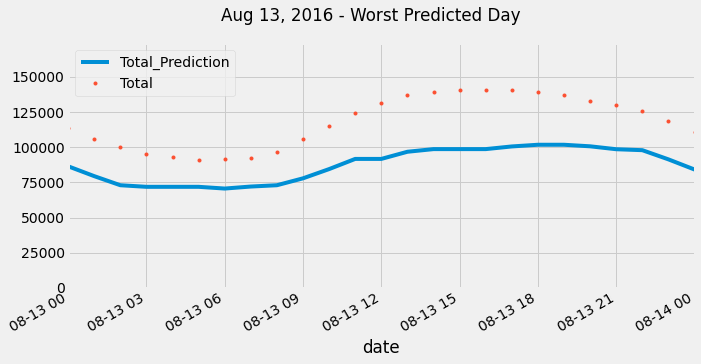

In [27]:
f, ax = pyplot.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = df_features_all[['Total_Prediction','Total']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, df_features_all[['Total_Prediction','Total']].max().max()+df_features_all[['Total_Prediction','Total']].max().max()*0.1)
ax.set_xbound(lower='2016-08-13', upper='2016-08-14')
plot = pyplot.suptitle('Aug 13, 2016 - Worst Predicted Day')

# Hyper-Paramètres

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
params = {}
params['booster'] = 'gbtree'
params['objective'] = 'binary:logistic'
params["eval_metric"] = "error"
params['eta'] = 0.3
params['gamma'] = 0
params['max_depth'] = 6
params['min_child_weight']=1
params['max_delta_step'] = 0
params['subsample']= 1
params['colsample_bytree']=1
params['silent'] = 1
params['seed'] = 0
params['base_score'] = 0.5
clf = xgb.XGBClassifier(params)

#Grid Search
# A parameter grid for XGBoost
params = {
    'min_child_weight': [3, 4],
    'gamma': [i / 10.0 for i in range(0, 4)],
    'subsample': [i / 10.0 for i in range(8, 11)],
    'colsample_bytree': [i / 10.0 for i in range(4, 6)],
    'max_depth': [2, 3, 4]}
# Initialize XGB and GridSearch
xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror')
grid = GridSearchCV(xgb_reg, params)
grid.fit(X_train, y_train,eval_metric="rmse")
gridcv_xgb = grid.best_estimator_

In [32]:
from sklearn.metrics import r2_score
print(r2_score(y_test, gridcv_xgb.predict(X_test)))
print ("Score Train -->", round(gridcv_xgb.score(X_test, y_test) *100,2), " %")
#print ("Score Train -->", round(gridcv_xgb.score(X_train, y_train) *100,2), " %")
#0.6583137888762818
#Score Train --> 65.83  %

0.6415136454531001
Score Train --> 64.15  %


In [33]:
rmse = np.sqrt(mean_squared_error(y_test, gridcv_xgb.predict(X_test)))
rmse

10085.355522314974

In [34]:
#Best Parameters
grid.best_params_
#0.6583137888762818
#Score Train --> 65.83  %
#{'colsample_bytree': 0.6,
# 'gamma': 0.3,
# 'max_depth': 3,
# 'min_child_weight': 4,
# 'subsample': 1.0}

#'min_child_weight': [3, 4],
#'gamma': [i / 10.0 for i in range(0, 4)],
#'subsample': [i / 10.0 for i in range(8, 11)],
#'colsample_bytree': [i / 10.0 for i in range(2, 6)],
#'max_depth': [2, 3, 4]}
#0.6415136454531001
#Score Train --> 64.15  %

{'colsample_bytree': 0.3,
 'gamma': 0.0,
 'max_depth': 4,
 'min_child_weight': 4,
 'subsample': 0.8}

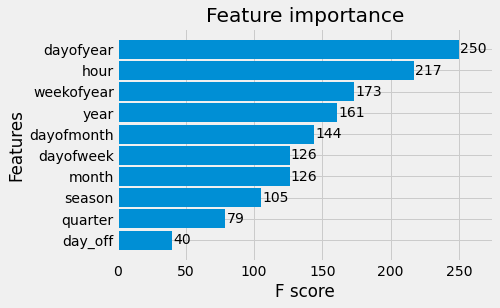

In [35]:
_ = xgboost.plot_importance(gridcv_xgb, height=0.9)#_ = xgboost.plot_importance(reg, height=0.9)

Evaluate the model

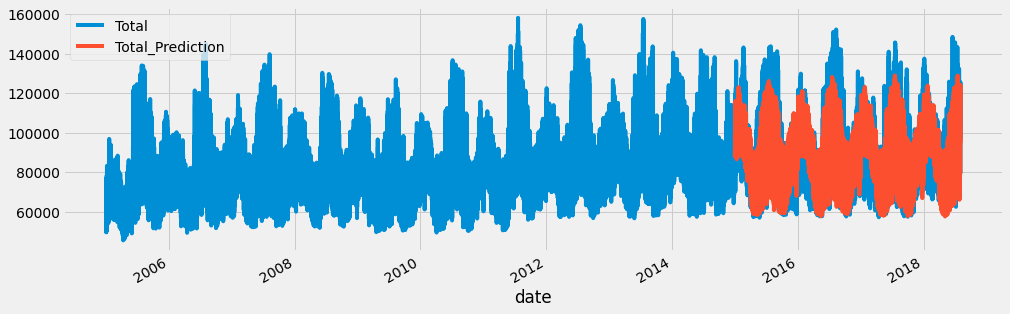

In [36]:
df_features_test['Total_Prediction'] = gridcv_xgb.predict(X_test)
df_features_all = pd.concat([df_features_test, df_features_train], sort=False)
_ = df_features_all[['Total','Total_Prediction']].plot(figsize=(15, 5))

Plot the forecast with the actuals

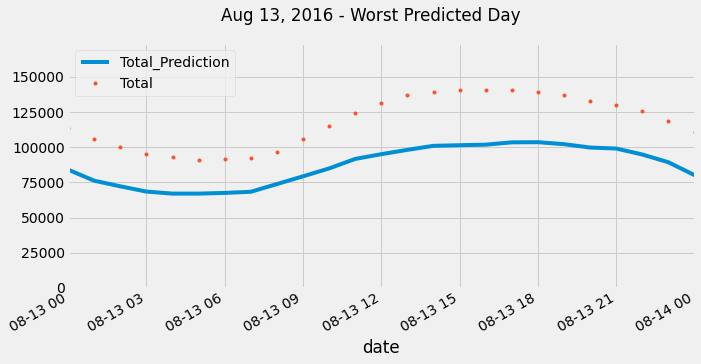

In [37]:
f, ax = pyplot.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = df_features_all[['Total_Prediction','Total']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, df_features_all[['Total_Prediction','Total']].max().max()+df_features_all[['Total_Prediction','Total']].max().max()*0.1)
ax.set_xbound(lower='2016-08-13', upper='2016-08-14')
plot = pyplot.suptitle('Aug 13, 2016 - Worst Predicted Day')

In [38]:
MAPE=mean_absolute_percentage_error(y_true=df_features_test['Total'],
                   y_pred=df_features_test['Total_Prediction'])
print ("We got a MAPE of : ", round(MAPE,2), " %")

We got a MAPE of :  8.45  %


In [39]:
#reg = XGBRegressor(n_estimators=1000)
#reg.fit(X_train, y_train,
#        eval_set=[(X_train, y_train), (X_test, y_test)],
#        early_stopping_rounds=50,
#       verbose=False) # Change verbose to True if you want to see it train
#p_boost = reg.predict(X_train)
#print ("Score Train -->", round(reg.score(X_train, y_train) *100,2), " %")

# Sauvegarde et chargement de modèle

In [40]:
#La librairie inclut aussi la possibilité de sauvegarder et recharger un modèle:
#Sauvegarde d’un modèle entraîné :
xgb._Booster.save_model('xgboostconsumption.xbmodel')

AttributeError: module 'xgboost' has no attribute '_Booster'

# Chargement d’un modèle sauvegardé :

In [ ]:
boost = xgb.Booster({'nthread': 4}) boost.load_model('xgboostconsumption.xbmodel')

# Create Forecast

Let’s read our “predictionempty.xlsx” dataset, we created on Excel before. Instead of creating a table here on Python, I used a simple Excel table. This is definitely the leanest way if you are aiming to progress fast & efficiently.

In [ ]:
test = pd.read_excel(‘predictionempty.xlsx’, parse_dates=[0], index_col=[0])

pred_x, pred_y = create_features(test, label='Total')

df_features_test['Total_Prediction'] = gridcv_xgb.predict(X_test)

test['Total_Prediction'] = gridcv_xgb.predict(pred_x)
test.head()

Let’s plot the future predictions:

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(training_df[‘Sold Units’][‘2019–09–01’:])
plt.plot(test.xgb_Prediction)
plt.show()

train_date_start = '2015-01-01'
test_date_start=test['date'].min()
datetime.datetime.strptime(test_date_start, "%y-%m-%d")
train_date_end = test['date'].min()- datetime.timedelta(days=1)

f, ax = pyplot.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
plt.plot(training_df[‘Sold Units’][‘2019–09–01’:])
plt.plot(test.xgb_Prediction)
#_ = df_features_all[['Total_Prediction','Total']].plot(ax=ax,
#                                              style=['-','.'])
ax.set_ylim(0, test[['Total_Prediction']].max()+df_features_all[['Total_Prediction']].max().max()*0.1)
ax.set_xbound(lower=train_date_start, upper=test['date'].max())
plot = pyplot.suptitle(train_date_start + ' - Predicted Day')